In [208]:
%run main.ipynb
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### **1. Before Optimization**

In [209]:
# define current portfolio & import data
stocks = ['AMZN', 'GOOGL', 'MSFT', 'NVDA', 'VOO']
weights = [0.1962, 0.2806, 0.1449, 0.0873, 0.2910]
data = import_data(stocks)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


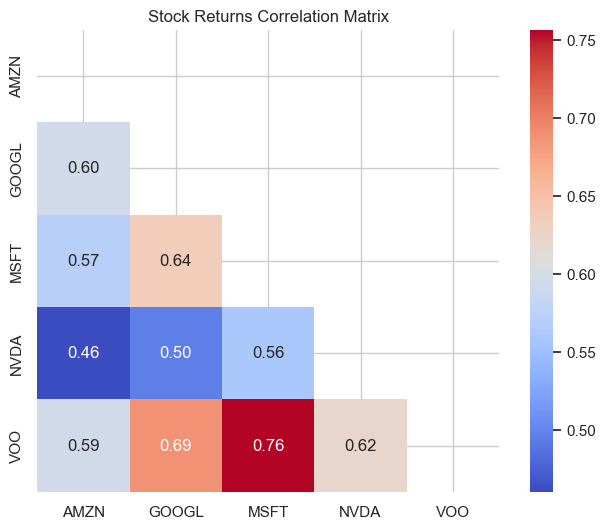

In [210]:
# create corrolation matrix
returns_data = pd.DataFrame({stock: data[stock]['Return'] for stock in data.keys()})
corr = returns_data.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title("Stock Returns Correlation Matrix")
plt.show()

#### **Insights from the Correlation Matrix**
- **Highest Correlation**:
    - MSFT & VOO &rarr; 0.76
    - GOOGL & VOO &rarr; 0.69
- **Moderate Correlation**:
    - AMZN & GOOGL &rarr; 0.60
    - MSFT & GOOGL &rarr; 0.64
- **Lowest Correlation**:
    - NVDA & GOOGL &rarr; 0.50
    - NVDA & AMZN &rarr; 0.46

The correlation matrix reveals that MSFT, GOOGL, and VOO are highly correlated, indicating significant exposure to overall market movements. NVDA has the lowest correlations, providing diversification.

#### **Value at Risk (VaR)**

Value at Risk (VaR) estimates the maximum expected loss of a portfolio over a given period at a specific confidence level. VaR is defined as,

$VaR_a = \text{Percentile}_{1-\alpha}\text{(Portfolio Returns)}$

where:
- $\alpha$ = Confidence level (held at 95%)
- $\text{Portfolio Returns}$ = Weighted sum of stock returns

In [211]:
# compute VaR (value at risk) at confidence level 95%
def value_at_risk(data, weights, confidence_level=0.95):
    returns_data = pd.DataFrame({stock: data[stock]['Return'] for stock in data.keys()})
    returns_data.dropna(inplace=True)
    # compute portfolio daily returns
    portfolio_returns = np.dot(returns_data, weights)
    # compute VaR
    var = np.percentile(portfolio_returns, 100 * (1 - confidence_level))
    
    return var

var = value_at_risk(data, weights)
print('Portfolio VaR: ' + str(var))

Portfolio VaR: -0.022191190743305274


A VaR of -2.21% at a 95% confidence level tells me that under normal market conditions, my portfolio expects to lose no more than 2.22% in one day with a 95% probability. There is a 5% chance the losses could exceed this amount.

#### **Conditional Value at Risk (CVaR)**

To measure the expected loss in worst-case scenarios, we use Conditional Value at Risk (CVaR).

$CVaR_\alpha = E[R|R \leq VaR_\alpha]$

where:
- $VaR_\alpha$ = VaR at confidence level $\alpha$
- $E[R|R \leq VaR_\alpha]$ = Expected loss beyond the VaR threshold

In [212]:
# compute CVaR (conditional value at risk) at confidence level 95%
def conditional_value_at_risk(data, weights, confidence_level=0.95):
    returns_data = pd.DataFrame({stock: data[stock]['Return'] for stock in data.keys()})
    returns_data.dropna(inplace=True)
    portfolio_returns = np.dot(returns_data, weights)
    # compute VaR
    var = value_at_risk(data, weights)
    # compute CVaR
    cvar = portfolio_returns[portfolio_returns <= var].mean()
    return cvar

cvar = conditional_value_at_risk(data, weights)
print('Portfolio CVaR: ' + str(cvar))

Portfolio CVaR: -0.032743157418874236


A CVaR of -3.27% at a 95% confidence level tell me that in the worst 5% cases, my portfolio's average daily loss is expected to be at least 3.27%.

In [213]:
# compute portfolio volatility
p_volatility = portfolio_volatility(data, weights)
print('Volatility: ' + str(p_volatility))

# compute expected portfolio return
p_return = portfolio_return(data, weights)
print('Expected Portfolio Return: ' + str(p_return))

# compute Sharpe Ratio
sharpe = sharpe_ratio(data, weights)
print('Share Ratio: ' + str(sharpe))

Volatility: 0.2209766850536758
Expected Portfolio Return: 0.26467583397435607
Share Ratio: 1.016739996438003


#### **Before Optimization Portfolio Analysis**

We have calculated the following metrics for my portfolio before optmization:

| Metric | Value |
|-|-|
| VaR (95%) | -2.21\% |
| CVaR (95%) | -3.27\% |
| Volatility | 28.70\% |
| Return | 40.99\% |
| Sharpe Ratio | 1.29 |

#### **Exploring Portfolio Risk and Return**

Next, we generate 500 random portfolio weight combinations and evaluate their expected return, volatility, and Sharpe Ratio. My goal is to visualize the trade-off between risk and return and identify portfolios with the best risk-adjusted performance.

In [214]:
# generate n random weights
def generate_random_weights(n):
    rand_nums = np.random.rand(n)
    return rand_nums / sum(rand_nums)

In [215]:
# sample 500 random weights
weights_random = np.array([generate_random_weights(len(stocks)) for i in range(500)])

In [216]:
# calculate sharpe ratios
sharpe_ratios = {}
for j in range(len(weights_random)):
    sharpe = sharpe_ratio(data, weights_random[j])
    sharpe_ratios[j] = sharpe

# calculate expected portfolio returns
portfolio_returns = {}
for k in range(len(weights_random)):
    p_return = portfolio_return(data, weights_random[k])
    portfolio_returns[k] = p_return

# calculate volatility
volatilities = {}
for l in range(len(weights_random)):
    volatility = portfolio_volatility(data, weights_random[l])
    volatilities[l] = volatility

# stick everything in a dataframe
random_weights_df = pd.DataFrame({
    'Portfolio': list(portfolio_returns.keys()),
    'Expected Return': list(portfolio_returns.values()),
    'Volatility': list(volatilities.values()),
    'Sharpe Ratio': list(sharpe_ratios.values()),
})

random_weights_df.set_index('Portfolio', inplace=True)

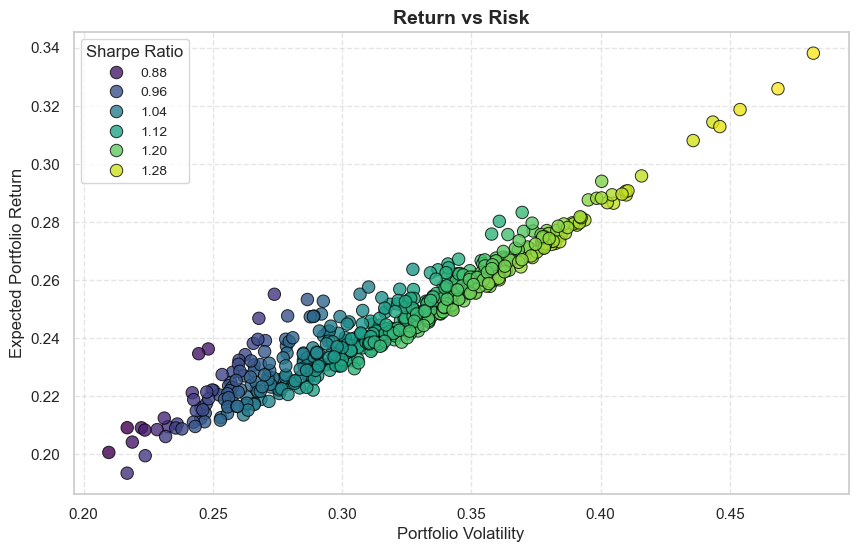

In [217]:
# plot scatterplot (return vs risk)
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=random_weights_df, 
                x="Expected Return", 
                y="Volatility",
                hue="Sharpe Ratio",
                palette="viridis",
                edgecolor="black",
                s=80,
                alpha=0.8
)

plt.title('Return vs Risk', fontsize=14, fontweight='bold')
plt.xlabel('Portfolio Volatility', fontsize=12)
plt.ylabel('Expected Portfolio Return', fontsize=12)
plt.legend(title="Sharpe Ratio", fontsize=10, title_fontsize=12, loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#### **Observations from the Graph**:

1. **Positive Correlation**: High portfolio volatility generally leads to higher expected returns
2. **Sharpe Ratio**: The scatterplot indicates higher sharpe ratios (i.e better risk-return tradeoffs) at the upper edge
3. **Diversification**: Some portfolios have similar returns at lower risk, which suggests optimal weight distributions
4. **Best Portfolios**: The portfolios with the highest Sharpe Ratios (yellow ones) are the most efficient, maximizing return per unit of risk

The graph shows that riskier portfolios have higher returns. The curve's shape suggests that some portfolios are better than others at balancing risk and return. The color gradient helps to pick out the most efficient portfolios, which offer the highest return for the amount of risk taken. Overall, this shows why it is important to get the right mix of stocks, a diversified portfolio can increase returns without undue risk.

### **2. After Optimization**

#### **Optimizing the Sharpe Ratio**

I will now use gradient ascent to maximize the Sharpe Ratio by manipulating the portfolio's weights. The algorithm will ieratively move in a direction towards improving risk-adjust return and will stop when it reaches an optimal point. 

In [218]:
weights = generate_random_weights(5)
optimize = portfolio_optimization(data, weights, alpha=0.5)

Total Iterations Completed: 52
Sharpe Ratio: 1.3248368116300675
Computed Optimal Portfolio: 
AMZN     30.05%
GOOGL     1.00%
MSFT     13.30%
NVDA     54.65%
VOO       1.00%
dtype: object


#### **Computed Optimal Portfolio**

| Stock | Weight |
|-|-|
| AMZN |  30.05% |
| GOOGL | 1.00% |
| MSFT | 13.30% |
| NVDA | 54.65% |
| VOO | 1.00% |

The algorithm converged in 52 iterations with a 1.3248 Sharpe Ratio, an improvement over my initial portfolio. The optimal weights show a significant shift, with NVDA having the highest allocation (54.65%), while GOOGL & VOO are minimized (1%).

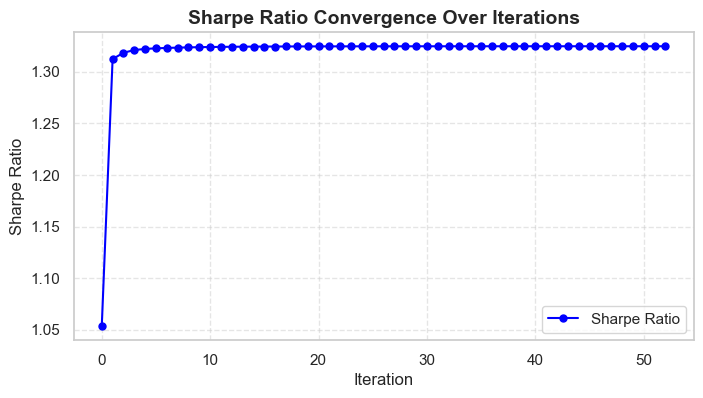

In [219]:
plt.figure(figsize=(8, 4))
plt.plot(optimize['Iteration'], optimize['Sharpe Ratio'], marker='o', color='blue', markersize='5', label='Sharpe Ratio')

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Sharpe Ratio', fontsize=12)
plt.title('Sharpe Ratio Convergence Over Iterations', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

#### **Convergence Over Iterations**

The graph above shows the Sharpe Ratio's convergence over iterations. The Sharpe Ratio starts low (~1.17) but then sharply climbs within the first 10 iterations, converging at 1.32. This shows the algorithm produces a fairly smooth convergence quickly and efficiently.

In [220]:
# define optimized weights
optimized_weights = np.array(optimize['Optimal Portfolio'])

# compute new VaR, CVaR, volatility, expected return, and sharpe ratio
optimized_var = value_at_risk(data, optimized_weights)
optimized_cvar = conditional_value_at_risk(data, optimized_weights)
optimized_volatility = portfolio_volatility(data, optimized_weights)
optimized_return = portfolio_return(data, optimized_weights)
optimized_sharpe = sharpe_ratio(data, optimized_weights)

print('New VaR: ' + str(optimized_var))
print('New CVaR: ' + str(optimized_cvar))
print('New Volatility: ' + str(optimized_volatility))
print('New Expected Portfolio Return: ' + str(optimized_return))
print('New Sharpe Ratio: ' + str(optimized_sharpe))

New VaR: -0.03213357730051542
New CVaR: -0.04673607347017947
New Volatility: 0.3318033083264395
New Expected Portfolio Return: 0.4795852370915083
New Sharpe Ratio: 1.3248368116300675


#### **Final Analysis: Before vs After Optimization**

| Metric | Before Optimization | After Optimization | Difference
|-|-|-|-|
| VaR | -2.21% | -3.21% | -1.00 |
| CVaR | -3.27% | -4.67% | -1.40 |
| Volatility | 28.70% | 33.18% | 4.40 |
| Return | 40.99% | 47.96% | 6.97 |
| Sharpe Ratio | 1.29 | 1.32 | 0.03 |

**1. Increased Return (+6.97%)**
- Expected return increased from 40.99% to 47.96%, showing the algorithm allocated more weight to higher-return assets.
- This suggests the algorithm shifted towards more aggresive stocks, prioritizing higher gains.

**2. Higher Volatility (+4.40)** 
- Portfolio volatility increased from 28.70% to 33.18%, showing the optimizer favored higher-risk stocks.
- This is to be expected, as we saw earlier that higher returns come with increased volatility.

**3. Greater Downside Risk (VaR and CVaR Decreased)**
- VaR decreased from -2.21% to -3.21%, indicating the optimized portfolio has higher potential daily loss at the 95% confidence level.
- CVaR also decreased from -3.27% to -4.67%, indicating average losses in extreme scenarios are now larger.
- This suggests the optimizer shifted weight towards more volatile stocks that carry higher downside risk.

**4. Improvement in Sharpe Ratio (+0.03)**
- The Sharpe Ratio improved from 1.29 to 1.32, indicating the optimized portfolio earns more return per unit of risk.
- This shows the optimizer did its job and successfully maximized the Sharpe Ratio.

### **Conclusion**

The optimization successfully increased expected returns while improving risk-adjusted performance (Sharpe Ratio). However, the increased downside risk indicates that this portfolio is better suited for more aggresive investors willing to accept higher volatility.

**Key Findings:**
- The optimized portfolio achieved a higher return (+6.79%), increasing from 40.99% to 47.96%
- Volatility increased (+4.40%), indicating a shift toward riskier stocks to get higher returns
- Downside risk got worse, with VaR dropping from -2.21% to -3.21% and CVaR from -3.27% to -4.67%
- The Sharpe Ratio improved from 1.29 to 1.32, showing the optimizer succesfully did its job

For a more balanced or conservative approach, further implementations could include risk constraints to limit volatility and extreme losses while still optimizing returns.

**Future Enhancements:**
- Implement Additional Constraints (e.g., capping volatility)
- Explore Other Optimization Techniques 
- Conduct Stress Testing to evaluate the portfolio’s performance under historical market crises.